# exma quick start

In this tutorial we will take the typical molecular dynamics case of a Lennard-Jones (LJ) fluid, in its solid phase and in its liquid phase, and we will see how to obtain different properties of them using this library.

This first part of the code will be common to all three sections. We are going to import the necessary libraries and define the variables that we will use next. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

We are going to define the _strings_ that will direct us to where the files with the paths are located (assuming we are in _exma/docs/source_).

In [2]:
fsolid = "tutorial_data/solid.xyz"
fliquid = "tutorial_data/liquid.xyz"

We leave these variables defined as strings and we do not read them since `exma` is in charge of reading xyz or lammpstrj files.
These trajectories were generated with a [homemade code](https://github.com/fernandezfran/tiny_md), in both cases there are 201 frames and 500 atoms. Next we define the parameters of the simulation cell for each case (this is necessary since the file is xyz, if it was lammpstrj we could skip this cell).

In [3]:
solid_box = np.full(3, 7.46901)
liquid_box = np.full(3, 8.54988)

In this case the distances are given in Lennard-Jones units.

## Mean Square Displacement (MSD)

The mean square displacement (MSD) is a measure of the deviation of the position of the particles with respect to a reference positions over time. From it, it is possible to obtain, through a linear regression, the trace diffusion coefficient. For more information you can start reading the Wikipedia article of [mean square displacement](https://en.wikipedia.org/wiki/Mean_squared_displacement).

We start by importing the `MeanSquareDisplacement` class from exma.

In [4]:
from exma import MeanSquareDisplacement

As in every Pair Analyzer, we have dedicated `calculate`, `plot` and `save` methods, the latter will not be used in this tutorial but it is useful when we want to save the results in a different file without the need to re-run the calculations which, for long time simulations, can be demanding.

In [5]:
# for both structures we discard the first 10 equilibration frames
solid_msd = MeanSquareDisplacement(fsolid, 0.05, "Ar", start=10, xyztype="image")
liquid_msd = MeanSquareDisplacement(fliquid, 0.05, "Ar", start=10, xyztype="image")

At this point we just instantiate the class, we are able to calculate, for which it is necessary to pass the optional argument of the cell length in each direction.

In [6]:
solid_msd.calculate(box=solid_box)

,t,msd
0,0.00,0.000000
1,0.05,0.015579
2,0.10,0.012065
3,0.15,0.014467
4,0.20,0.014905
...,...,...
186,9.30,0.014900
187,9.35,0.015280
188,9.40,0.014324
189,9.45,0.014695


In [7]:
liquid_msd.calculate(box=solid_box)

,t,msd
0,0.00,0.000000
1,0.05,0.249304
2,0.10,0.420926
3,0.15,0.574253
4,0.20,0.730512
...,...,...
186,9.30,28.461536
187,9.35,28.706202
188,9.40,28.750016
189,9.45,28.760514


We can see directly from the numbers how in the liquid phase a larger quadratic displacement is obtained already in the first steps. But to be more illustrative, we can plot both curves on the same graph, using `plt.gca()` of matplotlib.

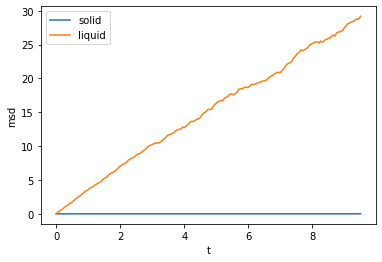

In [8]:
ax = plt.gca()

# we pass the same axis to both plots and define the labels offered by the wrapper to the plot function 
solid_msd.plot(ax=ax, plot_kws={"label": "solid"})
liquid_msd.plot(ax=ax, plot_kws={"label": "liquid"})

# we add the legend to the plot
plt.legend()

We obtain the expected response for a LJ fluid where the liquid phase diffuses with the expected linear behaivor and the solid phase does not diffuse.

## Radial Distribution Function (RDF)

The pair radial distribution function (RDF), _g(r)_, characterizes the local structure of a fluid, and describes the probability to find an atom in a shell at distance _r_ from a reference atom. This quantity is calculated as the ratio between the average density at distance _r_ from the reference atom and the density at that same distance of an ideal gas. For more information you can start reading the Wikipedia article of [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function).

We start importing the `RadialDistributionFunction` class from exma.

In [9]:
from exma import RadialDistributionFunction

And the mode of use is quite analogous to that of the MSD, some parameters of the inizializer are changed.

In [10]:
# for both structures we discard the first 10 equilibration frames
solid_rdf = RadialDistributionFunction(fsolid, "Ar", "Ar", start=10, rmax=solid_box[0] / 2)
liquid_rdf = RadialDistributionFunction(fliquid, "Ar", "Ar", start=10, rmax=liquid_box[0] / 2)

In this case we declare that the RDF is calculated up to half the distance from the box, i.e. atoms at a greater distance are ignored.

In [11]:
solid_rdf.calculate(box=solid_box)

,r,rdf
0,0.018673,0.000000
1,0.056018,0.000000
2,0.093363,0.000000
3,0.130708,0.000000
4,0.168053,0.000000
...,...,...
95,3.566452,0.779633
96,3.603797,0.791239
97,3.641142,0.879388
98,3.678487,1.032154


In [12]:
liquid_rdf.calculate(box=liquid_box)

,r,rdf
0,0.021375,0.000000
1,0.064124,0.000000
2,0.106874,0.000000
3,0.149623,0.000000
4,0.192372,0.000000
...,...,...
95,4.082568,1.017443
96,4.125317,1.013300
97,4.168067,1.007181
98,4.210816,1.000252


As before, we can obtain the corresponding graph.

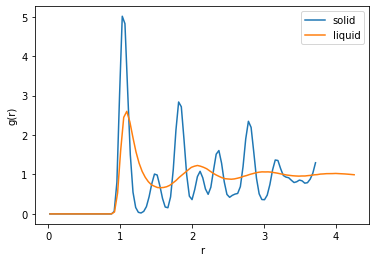

In [13]:
ax = plt.gca()

# we pass the same axis to both plots and define the labels offered by the wrapper to the plot function 
solid_rdf.plot(ax=ax, plot_kws={"label": "solid"})
liquid_rdf.plot(ax=ax, plot_kws={"label": "liquid"})

# we add the legend to the plot
plt.legend()

We get the expected results. For the solid phase we have the defined peaks of an fcc crystal with noise given by the temperature and for the liquid phase we get the usual behavior of a liquid. For both systems we have that the g(r) oscillates around 1 for larger distances.

## Coordination Number (CN)

The coordination number (CN), also called ligancy, of a given atom in a chemical system is defined as the number of atoms, molecules or ions bonded to it. This quantity is calculated considered the number of neighbors surrounding a given atom type a cutoff distance.

From the previous graph we can define the cut-off radius to consider only the first neighbors.

In [14]:
solid_rcut = 1.29
liquid_rcut = 1.56

Now we import the `CoordinationNumber` class.

In [15]:
from exma import CoordinationNumber

We have the same conduct as in the previos classes.

In [16]:
solid_cn = CoordinationNumber(fsolid, "Ar", "Ar", solid_rcut, start=10)
liquid_cn = CoordinationNumber(fliquid, "Ar", "Ar", liquid_rcut, start=10)

In this case there is no point in making a plot, so the `calculate` method directly gives us the mean and standard deviation of the number of coordination calculated over all the production frames.

In [17]:
solid_cn.calculate(box=solid_box)

(12.006931937172777, 0.007931589852952529)

In [18]:
liquid_cn.calculate(box=liquid_box)

(12.220104712041884, 0.10884996812826905)

For both cases we have roughly the same result of the CN close to 12 typical value of a compact packing structure, as is the _fcc_ crystal and its amorphization.